**S12 Tableau**

**BUHION, Deborah**

**DELA CRUZ, Alexis**

**DIZON, Michaela**

**GO, Thea**

**OAFALLAS, Kenneth**

# Exercise: EDA

This exercise is a continuation of the exploratory data analysis of the Citibike Trip Histories dataset. The first section shows code to prepare the data, followed by a section of the initial analysis. Your task is complete the EDA of the Citibike dataset. The instructions are stated in the last section of this notebook.

**IMPORTANT:** Copy this notebook and make changes in that copy. Do not push changes to this notebook.

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data - CitiBike Trip Histories

CitiBike provides the data of the bike share through this website: https://www.citibikenyc.com/system-data

For this exercise, we'll be using their trip history data which may be found [here](https://s3.amazonaws.com/tripdata/index.html). 

In [2]:
data = pd.read_csv(os.getenv('DSDATA') + '/202102-citibike-tripdata.csv')
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,304,2021-02-01 00:04:23.0780,2021-02-01 00:09:27.7920,3175,W 70 St & Amsterdam Ave,40.777480,-73.982886,4045,West End Ave & W 60 St,40.772370,-73.990050,27451,Subscriber,1996,2
1,370,2021-02-01 00:07:08.8080,2021-02-01 00:13:19.4670,3154,E 77 St & 3 Ave,40.773142,-73.958562,3725,2 Ave & E 72 St,40.768762,-73.958408,35000,Subscriber,1991,1
2,635,2021-02-01 00:07:55.9390,2021-02-01 00:18:31.0390,502,Henry St & Grand St,40.714211,-73.981095,411,E 6 St & Avenue D,40.722281,-73.976687,49319,Subscriber,1980,2
3,758,2021-02-01 00:08:42.0960,2021-02-01 00:21:20.7820,3136,5 Ave & E 63 St,40.766368,-73.971518,3284,E 88 St & Park Ave,40.781411,-73.955959,48091,Customer,1969,0
4,522,2021-02-01 00:09:32.6820,2021-02-01 00:18:15.4100,505,6 Ave & W 33 St,40.749013,-73.988484,3687,E 33 St & 1 Ave,40.743227,-73.974498,48596,Subscriber,1988,1


## Feature Extraction

In [3]:
data['starttime'] = pd.to_datetime(data['starttime'])
data['stoptime'] = pd.to_datetime(data['stoptime'])

data['dayofweek'] = data['starttime'].dt.dayofweek
data['hourofday'] = data['starttime'].dt.hour
data['year'] = data['starttime'].dt.year

## Feature Transformation

In [4]:
data['duration_min'] = data['tripduration']/60

## Feature Generation

In [5]:
data['age'] = data['starttime'].dt.year - data['birth year']
data.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,dayofweek,hourofday,year,duration_min,age
0,304,2021-02-01 00:04:23.078,2021-02-01 00:09:27.792,3175,W 70 St & Amsterdam Ave,40.777480,-73.982886,4045,West End Ave & W 60 St,40.772370,-73.990050,27451,Subscriber,1996,2,0,0,2021,5.066667,25
1,370,2021-02-01 00:07:08.808,2021-02-01 00:13:19.467,3154,E 77 St & 3 Ave,40.773142,-73.958562,3725,2 Ave & E 72 St,40.768762,-73.958408,35000,Subscriber,1991,1,0,0,2021,6.166667,30
2,635,2021-02-01 00:07:55.939,2021-02-01 00:18:31.039,502,Henry St & Grand St,40.714211,-73.981095,411,E 6 St & Avenue D,40.722281,-73.976687,49319,Subscriber,1980,2,0,0,2021,10.583333,41
3,758,2021-02-01 00:08:42.096,2021-02-01 00:21:20.782,3136,5 Ave & E 63 St,40.766368,-73.971518,3284,E 88 St & Park Ave,40.781411,-73.955959,48091,Customer,1969,0,0,0,2021,12.633333,52
4,522,2021-02-01 00:09:32.682,2021-02-01 00:18:15.410,505,6 Ave & W 33 St,40.749013,-73.988484,3687,E 33 St & 1 Ave,40.743227,-73.974498,48596,Subscriber,1988,1,0,0,2021,8.700000,33


#### Distance

Another feature we can generate from the data is distance. Although the provided values are in longitude and latitudes and they're measured in degrees, the distance calculated from these points would also be in degrees (and not meters). 

There's actually a library that specifically handles geospatial data called `geopy` ([Link](https://geopy.readthedocs.io/en/stable/#module-geopy.distance)). For simplicity sake in this tutorial, we use an existing function that calculates the geodesic distance using the Haversine formula given the starting and ending longitude and latitudes: `calculate_distance(lat1, lon1, lat2, lon2)`

Credits to [Wayne Dyck](https://gist.github.com/rochacbruno/2883505) for the function.

In [6]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculates the distance provided a pair of longitudes and latitudes
    using the Haversine formula
    
    Returns the distance in kilometers.
    """
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

In [7]:
data['distance_km'] = data.apply(lambda x: calculate_distance(x['start station latitude'], x['start station longitude'],
                                        x['end station latitude'], x['end station longitude']), axis=1)

# Exploratory Data Analysis

We will do the following:
1. Examine the size and structure of the data
2. Examine each field individually
3. Examine relationships/correlations
4. Identify anomalies/outliers

## 1. Size and structure of the data

In [8]:
data.shape

(634631, 21)

After feater transformations, the dataset now has 634,631 observations with 21 variables.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634631 entries, 0 to 634630
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   tripduration             634631 non-null  int64         
 1   starttime                634631 non-null  datetime64[ns]
 2   stoptime                 634631 non-null  datetime64[ns]
 3   start station id         634631 non-null  int64         
 4   start station name       634631 non-null  object        
 5   start station latitude   634631 non-null  float64       
 6   start station longitude  634631 non-null  float64       
 7   end station id           634631 non-null  int64         
 8   end station name         634631 non-null  object        
 9   end station latitude     634631 non-null  float64       
 10  end station longitude    634631 non-null  float64       
 11  bikeid                   634631 non-null  int64         
 12  usertype        

The dataset has a variety of datatypes: integer and float values, date and time, and strings. There are no variables with null/missing values.

In [10]:
# Get descriptive statistics of quantitative variables
data.describe()

,tripduration,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,birth year,gender,dayofweek,hourofday,year,duration_min,age,distance_km
count,6.346310e+05,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.000000,634631.0,634631.000000,634631.000000,634631.000000
mean,1.044040e+03,2113.291434,40.741955,-73.976605,2113.355662,40.741686,-73.976779,41295.079259,1971.745553,0.342484,3.147275,14.011964,2021.0,17.400660,49.254447,1.840111
std,1.206238e+04,1576.082952,0.034753,0.022764,1576.501895,0.034642,0.022868,7149.176733,8.307802,0.608901,1.865895,4.586800,0.0,201.039591,8.307802,1.562775
min,6.100000e+01,72.000000,40.644512,-74.023087,72.000000,40.644512,-74.043991,14534.000000,1885.000000,0.000000,0.000000,0.000000,2021.0,1.016667,17.000000,0.000000
25%,3.450000e+02,438.000000,40.718822,-73.992573,437.000000,40.718822,-73.993012,36480.000000,1969.000000,0.000000,2.000000,11.000000,2021.0,5.750000,52.000000,0.786475
50%,5.930000e+02,3115.000000,40.741740,-73.981540,3115.000000,40.741459,-73.981687,42766.000000,1969.000000,0.000000,3.000000,15.000000,2021.0,9.883333,52.000000,1.396765
75%,1.036000e+03,3538.000000,40.764719,-73.961255,3537.000000,40.763954,-73.961199,47762.000000,1969.000000,1.000000,5.000000,17.000000,2021.0,17.266667,52.000000,2.411052
max,2.065242e+06,4419.000000,40.852252,-73.884308,4419.000000,40.852252,-73.884308,50133.000000,2004.000000,2.000000,6.000000,23.000000,2021.0,34420.700000,136.000000,17.937935


Although these variables are all quantitative, it doesn't really make sense to look at the statistics for unique IDs and spatial data like `start station id`, `start station latitude`, `start station longitude`, and `bikeid`, among others. Here, we will just focus on the values for `birth year`, `duration_min`, `age`, and `distance_km`.

Few insights from the `data.describe()` function:

1. The minimum `birth year` is 1885 which has a remarkably large difference from the 25th percentile value. Can this be anomalous data?
2. There is a very large difference between the maximum and 75th percentile values of `duration_min` and `age`.
3. Observations #1 & #2 indicate possible outliers in the data. 

In [11]:
data.describe(include=np.object)

,start station name,end station name,usertype
count,634631,634631,634631
unique,1274,1283,2
top,1 Ave & E 68 St,1 Ave & E 68 St,Customer
freq,4251,4226,468459


These are the descriptive stats for the categorical variables. 

## 2. Examining individual variables

Now, we can start generating simple visualizations to help us better understand the values in each variable.

#### User type

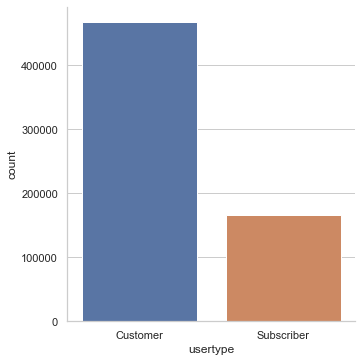

In [12]:
sns.set_theme(style="whitegrid")

usertype_plot = sns.catplot(x="usertype", kind="count", order=["Customer", "Subscriber"], data=data)

There are more one-time users of CitiBike than there are subscribers.

#### Age

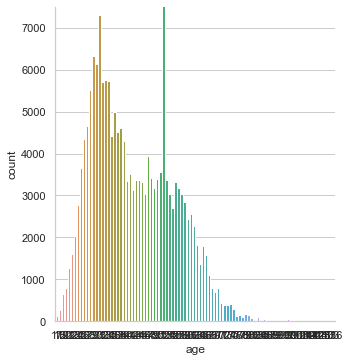

In [13]:
age_plot = sns.catplot(x="age", kind="count", data=data)
age_plot.set(ylim=(0,7500)) # Limit the maximum y-axis value because of one outlier count for age 52

In [14]:
data["age"].value_counts()

52     464712
31       7312
29       6327
30       6135
33       5758
        ...  
103         2
93          2
130         2
88          2
136         1
Name: age, Length: 92, dtype: int64

#### Starting Stations

In [15]:
start_stations = data["start station name"].value_counts().rename_axis('Station name').reset_index(name='counts')
start_stations = start_stations.nlargest(10, 'counts')
start_stations

,Station name,counts
0,1 Ave & E 68 St,4251
1,W 21 St & 6 Ave,3762
2,E 17 St & Broadway,3230
3,W 33 St & 7 Ave,3213
4,E 13 St & Avenue A,3044
5,E 33 St & 1 Ave,2970
6,Broadway & W 60 St,2757
7,Grand St & Elizabeth St,2700
8,Clinton St & Grand St,2620
9,Pershing Square North,2606


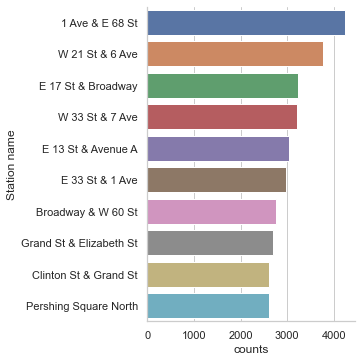

In [16]:
start_station_plot = sns.catplot(y="Station name", x="counts", orient="h", kind="bar", data=start_stations)

#### Ending stations

In [17]:
end_stations = data["end station name"].value_counts().rename_axis('Station name').reset_index(name='counts')
end_stations = end_stations.nlargest(10, 'counts')
end_stations

,Station name,counts
0,1 Ave & E 68 St,4226
1,W 21 St & 6 Ave,3734
2,E 17 St & Broadway,3481
3,W 33 St & 7 Ave,3161
4,E 13 St & Avenue A,3043
5,E 33 St & 1 Ave,3004
6,Broadway & W 60 St,2789
7,Grand St & Elizabeth St,2723
8,Pershing Square North,2622
9,Clinton St & Grand St,2611


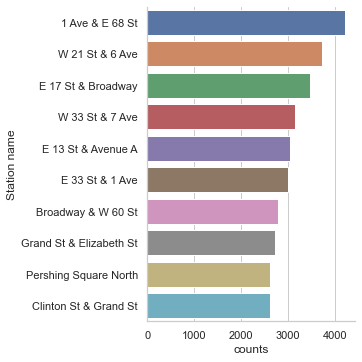

In [18]:
end_station_plot = sns.catplot(y="Station name", x="counts", orient="h", kind="bar", data=end_stations)

We can see from both plots that the top 10 start and end stations are consistent with each other. This indicates high taffic areas which can be potential locations for adding more bikes and bike docks. 

#### Origin-Destination Pairs

Here we create `od_trips` which contains the origin-destination pairs derived from the unique pairs of `start station name` and `end station name`.

In [19]:
## Count of rides per OD
od_trips = data.groupby(['start station name', 'end station name'], as_index=False)['bikeid'].count()
od_trips = od_trips.rename(columns={"start station name": "start", "end station name": "end", "bikeid": "total_trips"}, errors="raise")
od_trips.head()

,start,end,total_trips
0,1 Ave & E 110 St,1 Ave & E 110 St,17
1,1 Ave & E 110 St,1 Ave & E 68 St,11
2,1 Ave & E 110 St,1 Ave & E 78 St,1
3,1 Ave & E 110 St,1 Ave & E 94 St,2
4,1 Ave & E 110 St,2 Ave & E 104 St,2


In [20]:
od_trips["od"] = od_trips["start"] + " to " + od_trips["end"]
od_trips

,start,end,total_trips,od
0,1 Ave & E 110 St,1 Ave & E 110 St,17,1 Ave & E 110 St to 1 Ave & E 110 St
1,1 Ave & E 110 St,1 Ave & E 68 St,11,1 Ave & E 110 St to 1 Ave & E 68 St
2,1 Ave & E 110 St,1 Ave & E 78 St,1,1 Ave & E 110 St to 1 Ave & E 78 St
3,1 Ave & E 110 St,1 Ave & E 94 St,2,1 Ave & E 110 St to 1 Ave & E 94 St
4,1 Ave & E 110 St,2 Ave & E 104 St,2,1 Ave & E 110 St to 2 Ave & E 104 St
...,...,...,...,...
164369,Wythe Ave & Metropolitan Ave,Willoughby Ave & Tompkins Ave,2,Wythe Ave & Metropolitan Ave to Willoughby Ave...
164370,Wythe Ave & Metropolitan Ave,Willoughby Ave & Walworth St,1,Wythe Ave & Metropolitan Ave to Willoughby Ave...
164371,Wythe Ave & Metropolitan Ave,Willoughby St & Fleet St,1,Wythe Ave & Metropolitan Ave to Willoughby St ...
164372,Wythe Ave & Metropolitan Ave,Wyckoff Av & Stanhope St,1,Wythe Ave & Metropolitan Ave to Wyckoff Av & S...


C:\Users\Kenneth\anaconda3\lib\site-packages\seaborn\axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


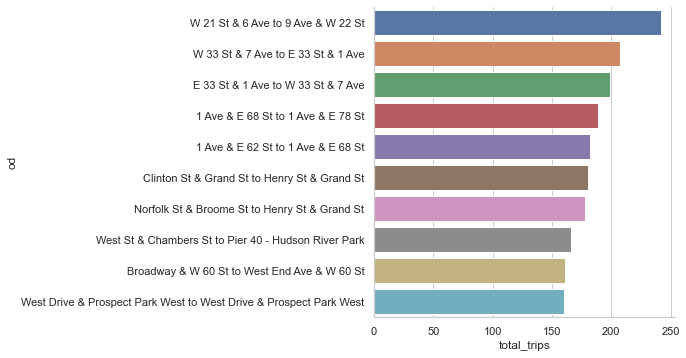

In [21]:
od_rank_plot = sns.catplot(y="od", x="total_trips", orient="h", kind="bar", data=od_trips.nlargest(10, "total_trips"))

#### Origin-Destination Matrix

In this part, we focus on analyzing the number of trips between the top 10 `start` and `end` stations. It would be impossible to visually analyze for all possible pairs because the dataset is too big.

In [22]:
# Get the trips between the top 10 stations.

od_topten = od_trips[od_trips.start.isin(start_stations["Station name"]) & od_trips.end.isin(end_stations["Station name"])]
od_topten

,start,end,total_trips,od
2318,1 Ave & E 68 St,1 Ave & E 68 St,87,1 Ave & E 68 St to 1 Ave & E 68 St
2433,1 Ave & E 68 St,Broadway & W 60 St,37,1 Ave & E 68 St to Broadway & W 60 St
2451,1 Ave & E 68 St,Clinton St & Grand St,2,1 Ave & E 68 St to Clinton St & Grand St
2482,1 Ave & E 68 St,E 13 St & Avenue A,8,1 Ave & E 68 St to E 13 St & Avenue A
2489,1 Ave & E 68 St,E 17 St & Broadway,9,1 Ave & E 68 St to E 17 St & Broadway
...,...,...,...,...
145506,W 33 St & 7 Ave,E 33 St & 1 Ave,207,W 33 St & 7 Ave to E 33 St & 1 Ave
145574,W 33 St & 7 Ave,Grand St & Elizabeth St,4,W 33 St & 7 Ave to Grand St & Elizabeth St
145621,W 33 St & 7 Ave,Pershing Square North,93,W 33 St & 7 Ave to Pershing Square North
145660,W 33 St & 7 Ave,W 21 St & 6 Ave,21,W 33 St & 7 Ave to W 21 St & 6 Ave


In [23]:
# Create a matrix

od_matrix = pd.pivot_table(od_topten, index='start', columns='end', values='total_trips', aggfunc=np.sum, fill_value=0)
od_matrix

end,1 Ave & E 68 St,Broadway & W 60 St,Clinton St & Grand St,E 13 St & Avenue A,E 17 St & Broadway,E 33 St & 1 Ave,Grand St & Elizabeth St,Pershing Square North,W 21 St & 6 Ave,W 33 St & 7 Ave
start,,,,,,,,,,
1 Ave & E 68 St,87,37,2,8,9,11,13,13,1,62
Broadway & W 60 St,35,89,1,0,6,1,1,9,2,6
Clinton St & Grand St,0,1,97,20,11,1,90,3,4,0
E 13 St & Avenue A,10,0,18,107,35,5,11,3,30,5
E 17 St & Broadway,4,3,9,46,81,22,8,20,78,13
E 33 St & 1 Ave,40,1,1,23,32,64,8,84,32,199
Grand St & Elizabeth St,1,0,96,15,15,8,70,0,16,0
Pershing Square North,31,9,3,8,20,108,0,27,11,84
W 21 St & 6 Ave,2,4,6,19,25,12,8,10,69,18


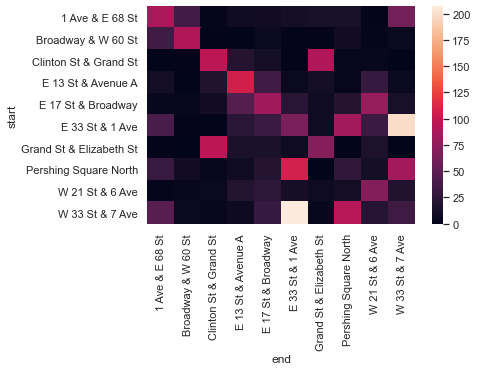

In [24]:
# Generate a heatmap

od_heatmap = sns.heatmap(od_matrix)

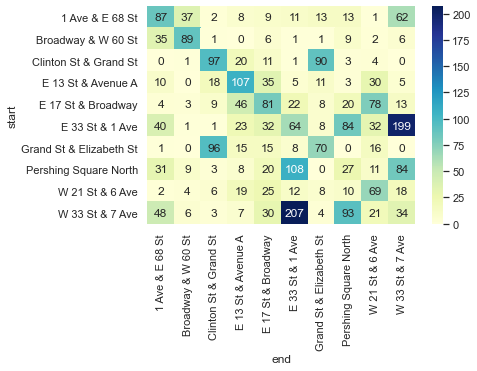

In [25]:
# Change color palette

od_heatmap = sns.heatmap(od_matrix, cmap="YlGnBu", annot=True, fmt="d")

#### Gender

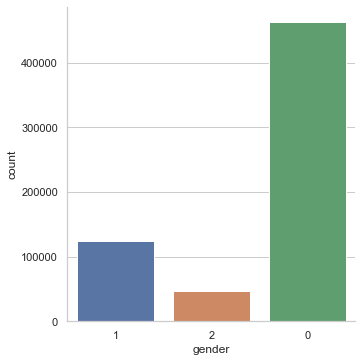

In [26]:
gender_plot = sns.catplot(x="gender", kind="count", order=[1, 2, 0], data=data)

It seems that the dataset contains mostly zero (0) values for the gender. We can continue our analysis by removing those trips with unknown gender.

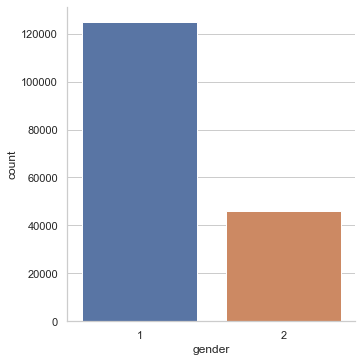

In [27]:
gender_plot = sns.catplot(x="gender", kind="count", order=[1, 2], data=data[data["gender"] > 0])

#### Day of week

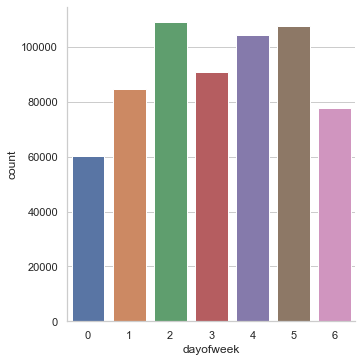

In [28]:
dow_plot = sns.catplot(x="dayofweek", kind="count", data=data)

The values for `dayofweek` starts with `0` or `Monday` and ends with `6` or `Sunday`. Based on the bar plot above, most trips happen on Wednesdays, Fridays and Saturdays.

#### Hour of day

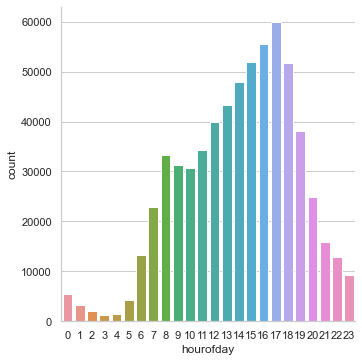

In [29]:
hod_plot = sns.catplot(x="hourofday", kind="count", data=data)

From the plot, the number of trips starts increasing from 12 noon and peaks at 5PM. 

#### Duration in minutes

In [30]:
data["duration_min"].describe()

count    634631.000000
mean         17.400660
std         201.039591
min           1.016667
25%           5.750000
50%           9.883333
75%          17.266667
max       34420.700000
Name: duration_min, dtype: float64

#### Detect and remove outliers

Outliers are defined as values that is more than 3 standard deviations away from the mean. Here, we detect them by computing the z score of each value, which is relative to the mean and standard deviation.

In [31]:
z_scores = zscore(data["duration_min"]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_entries = (abs_z_scores < 3) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
duration_min_outliers = (abs_z_scores >= 3)
data[duration_min_outliers].duration_min # Show outlier values

55        3793.983333
128       4257.516667
280       1364.983333
287       3014.366667
290       3205.933333
             ...     
631214    7005.816667
632255    1363.300000
633024    5281.700000
633398    6875.366667
633877    1165.300000
Name: duration_min, Length: 624, dtype: float64

#### Histograms with KDE

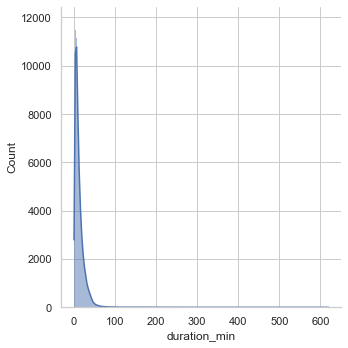

In [32]:
duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kde=True)

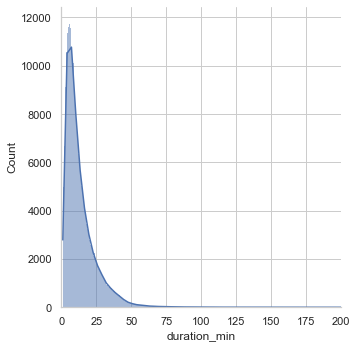

In [33]:
# Zoom in a little closer. Let's limit the x-axis to only show values up to 200

duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kde=True)
duration_plot.set(xlim=(0, 200))

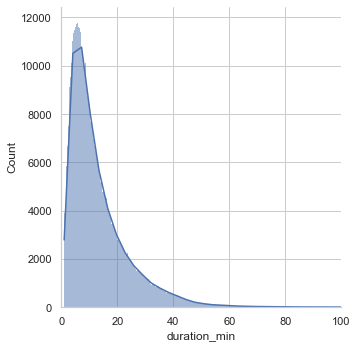

In [34]:
# Zoom in more. Let's limit the x-axis to only show values up to 100

duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kde=True)
duration_plot.set(xlim=(0, 100))

#### ECDF with Rug Plots

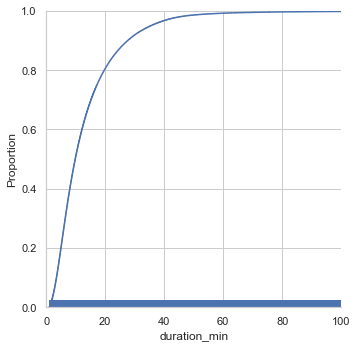

In [35]:
duration_plot = sns.displot(data=data[filtered_entries], x="duration_min", kind="ecdf", rug=True)
duration_plot.set(xlim=(0, 100))

## 3. Examine relationships/correlations

### User type and gender

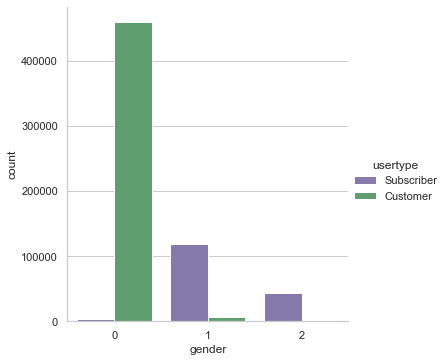

In [36]:
usertype_gender_plot = sns.catplot(x="gender", 
                                   kind="count", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   data=data)

- Users with 24-hour pass or 3-day passes did not have their gender information recorded.
- More male subscribers than females. 

### Trip distance, duration and user type

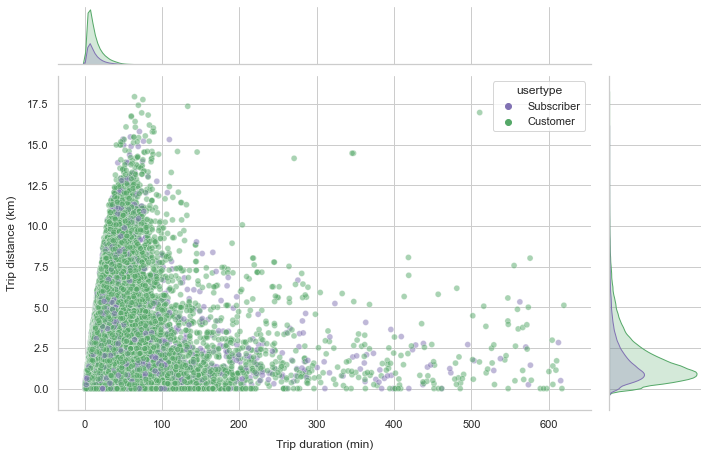

In [37]:
dur_dist_user_plot = sns.jointplot(data=data[filtered_entries], 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   alpha=0.5)
dur_dist_user_plot.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
dur_dist_user_plot.fig.set_size_inches(10.5, 6.5)

In [38]:
z_scores = zscore(data["distance_km"]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_dist = (abs_z_scores < 3) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
dist_outliers = (abs_z_scores >= 3)
data[dist_outliers].distance_km # Show outlier values

72        7.559672
79        6.791290
107       7.055636
123       7.133794
287       6.816675
            ...   
634021    8.016243
634081    7.339160
634088    8.447268
634167    7.635918
634521    6.830051
Name: distance_km, Length: 11992, dtype: float64

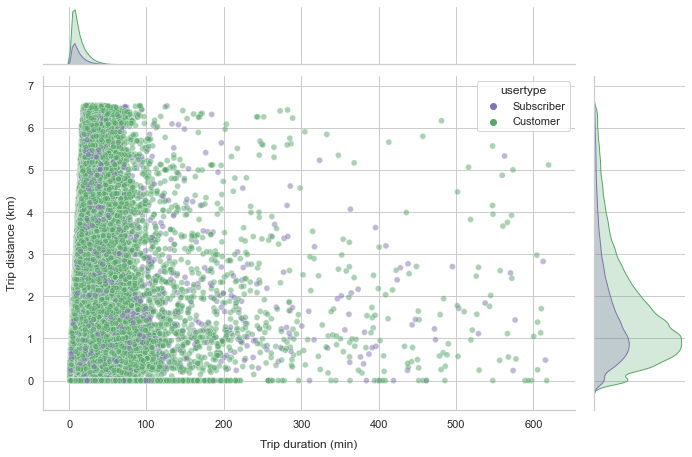

In [39]:
# Plot with outliers for both duration and distance
dur_dist_user_plot = sns.jointplot(data=data[filtered_entries & filtered_dist], 
                                   x="duration_min", 
                                   y="distance_km", 
                                   hue="usertype", 
                                   palette={"Customer": "g", "Subscriber": "m"}, 
                                   alpha=0.5)
dur_dist_user_plot.set_axis_labels("Trip duration (min)", "Trip distance (km)", labelpad=10)
dur_dist_user_plot.fig.set_size_inches(10.5, 6.5)

### Get correlation between quantitative variables

In [40]:
data_to_corr = data[["gender", "duration_min", "age", "distance_km"]]
data_to_corr

,gender,duration_min,age,distance_km
0,2,5.066667,25,0.828754
1,1,6.166667,30,0.487242
2,2,10.583333,41,0.971186
3,0,12.633333,52,2.124707
4,1,8.700000,33,1.342431
...,...,...,...,...
634626,1,2.250000,33,0.233175
634627,0,5.966667,52,0.555965
634628,0,4.816667,52,0.925453
634629,1,2.766667,35,0.632157


In [41]:
# Get z scores of the following variables
z_scores = zscore(data_to_corr[["duration_min", "age", "distance_km"]]) 

# Get their absolute values for easy filtering
abs_z_scores = np.abs(z_scores)

# An array of boolean values with same length as the original dataset. 
# True if value is less than 3 standard deviations from the mean or not an outlier. Otherwise, False.
filtered_rows = (abs_z_scores < 3).all(axis=1) 

# Array of boolean values where value is True if it is an outlier, otherwise False.
data_to_corr_outliers = (abs_z_scores >= 3)
data_to_corr[data_to_corr_outliers] # Show outlier values

,gender,duration_min,age,distance_km
25,1,19.883333,21,0.000000
28,1,18.783333,23,1.313043
32,1,4.600000,23,0.835615
33,1,21.833333,22,1.009758
37,1,6.316667,21,0.872510
...,...,...,...,...
634413,1,3.650000,79,0.435061
634474,0,43.750000,21,0.814466
634478,1,23.783333,23,4.652121
634521,0,41.866667,52,6.830051


In [42]:
# Remove outliers
data_to_corr = data_to_corr[filtered_rows]

#### Correlation Heatmap

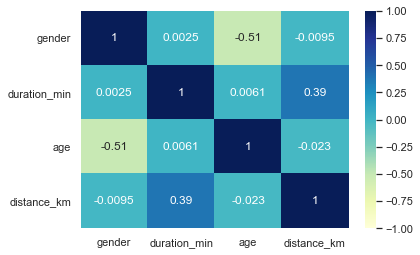

In [43]:
data_corr_heatmap = sns.heatmap(data_to_corr.corr(), 
                                center=0, 
                                cmap="YlGnBu", 
                                annot=True, 
                                vmin=-1, 
                                vmax=1)

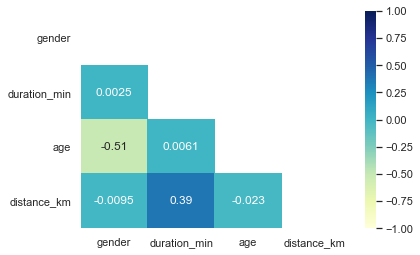

In [44]:
mask = np.triu(np.ones_like(data_to_corr.corr(), dtype=bool))

data_corr_heatmap = sns.heatmap(data_to_corr.corr(), 
                                center=0, 
                                cmap="YlGnBu", 
                                annot=True, 
                                mask=mask,
                                vmin=-1, 
                                vmax=1)

Variables `distance_km` and `duration_min` showed some positive correlation. We can still include them as features in a modeling task later.

----
----

# Exercise Proper: Continuation of EDA

We are already done in examining the individual characteristics of each variable in the dataset. You're task is to continue examining the remaining relationships (bivariate/multivariate) between variables. Here are some that you can prioritize:

1. Bivariate: Trip duration & time of day
2. Bivariate: User type & age
3. Bivariate: Start station & user type
4. Bivariate: End station & user type
5. Bivariate: End station & gender


1. Multi: Start station, end station & trip duration
2. Multi: Start station, end station & unique users
3. Multi: Start station, end station & user type
4. Multi: Trip distance, duration & gender
5. Multi: Average trip distance per unique user, average duration per unique user & user type
6. Multi: Average trip distance per unique user, average duration per unique user, gender & user type

After creating simple visualizations for each, write down your observations in a separate cell. You do not have to interpret yet why those relationships appear. We're still doing EDA. Relax ;)

### Bivariate 1: Trip duration & time of day

In [45]:
hod_td = data.groupby('hourofday', as_index=False).agg({'tripduration':'mean'})

hod_td

,hourofday,tripduration
0,0,1225.017605
1,1,1901.006184
2,2,1500.424008
3,3,3195.272657
4,4,1105.313837
5,5,730.054222
6,6,700.218506
7,7,882.274163
8,8,884.025271
9,9,901.614792


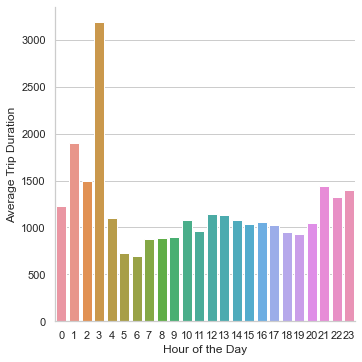

In [46]:
hod_duration = sns.catplot(x="hourofday", y="tripduration", kind="bar", data=hod_td)
hod_duration.set_axis_labels("Hour of the Day","Average Trip Duration")

**Observations:**

The average trip duration during dawn and evening are higher compared to the trip duration in daytime.

The value of the average trip duration at 3AM is significantly higher than all of the other hours of the day, there is a possibility that this feature contains an outlier.

### Bivariate 2: User Type vs Age

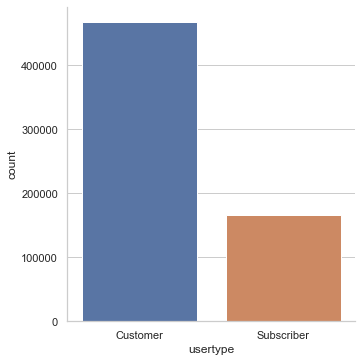

In [47]:
usertype_plot = sns.catplot(x="usertype", kind="count", order=["Customer", "Subscriber"], data=data)

The plot shows that there are significantly more `one time customers` than `subscribers`

#### Customer Age Distribution

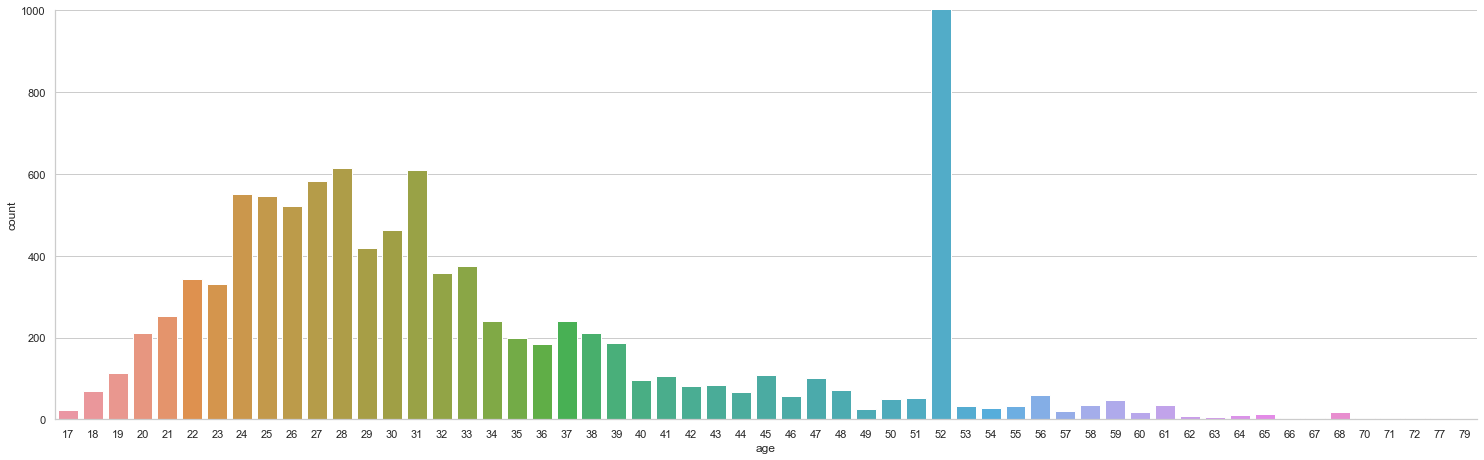

In [48]:
customer_age_plot = sns.catplot(x="age", kind="count", data=data[data['usertype'] == 'Customer'])
customer_age_plot.set(ylim=(0,1000)) # Limit max y-axis value because of age 52 outlier
customer_age_plot.fig.set_size_inches(25, 6.5)

Observations
1. The count for `52-year old subscribers` is a massive outlier
2. Customer age distribution seems to be left-skewed

#### Subscriber Age Distribution

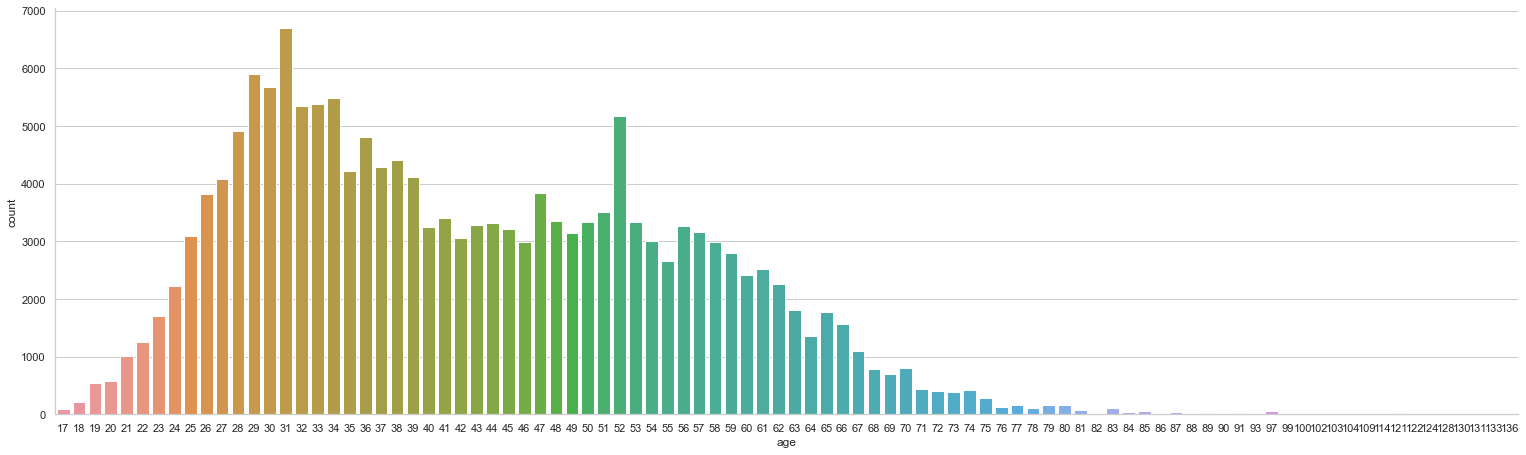

In [49]:
subscriber_age_plot = sns.catplot(x="age", kind="count", data=data[data['usertype'] == 'Subscriber'])
subscriber_age_plot.fig.set_size_inches(25, 6.5)

Observations
1. Subscriber age distribution seems to be right-skewed
2. Although the count is not too large, there may still be a possibility of outlier in the count of `52-year old subscribers` as it is significantly larger than in surrounding ages.

#### Customer vs Subscriber Age Distribution

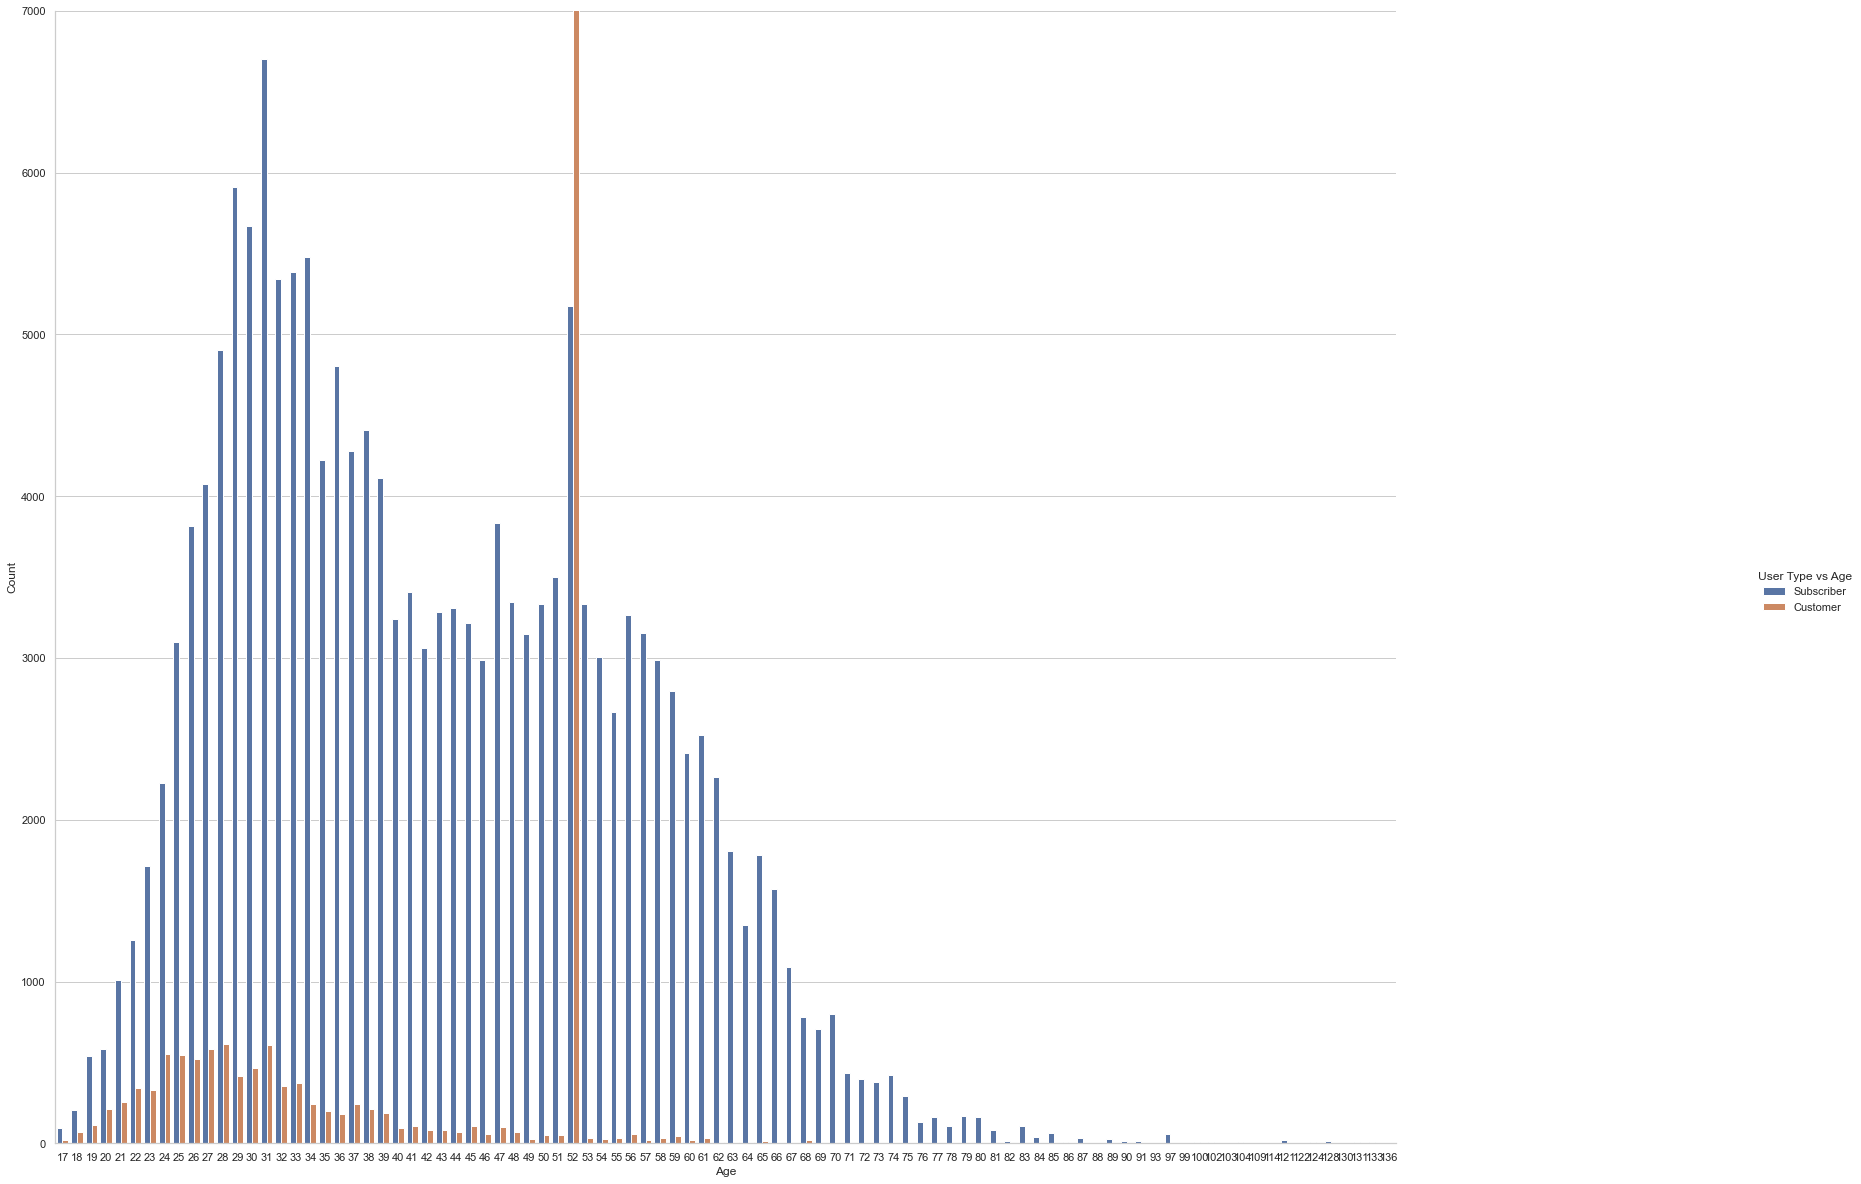

In [50]:
usertype_age_plot = sns.catplot(
    data=data, kind="count",
    x="age", hue="usertype", 
)
usertype_age_plot.set(ylim=(0,7000))
usertype_age_plot.set_axis_labels("Age", "Count")
usertype_age_plot.legend.set_title("User Type vs Age")
usertype_age_plot.fig.set_size_inches(30, 18)

Observations

1. In an earlier plot, there are significantly more `one time customers` than `subscribers`. It turns out that there are actually more `subscribers` because the number of `one time customers` was padded by age 52 outliers
2. The distribution of `customers` and `subscribers` in the dataset is very imbalanced
3. Most `subscribers` are in their `20s` to `50s`, while most `one time customers` are in their `20s` to `30s`

### Bivariate 3: Start station & user type

In [51]:
start_stations

,Station name,counts
0,1 Ave & E 68 St,4251
1,W 21 St & 6 Ave,3762
2,E 17 St & Broadway,3230
3,W 33 St & 7 Ave,3213
4,E 13 St & Avenue A,3044
5,E 33 St & 1 Ave,2970
6,Broadway & W 60 St,2757
7,Grand St & Elizabeth St,2700
8,Clinton St & Grand St,2620
9,Pershing Square North,2606


In [52]:
ss_utype = data[data['start station name'].isin(start_stations['Station name'])].groupby(['start station name','usertype']).count()
ss_utype = ss_utype['bikeid'].reset_index(name='counts')
ss_utype

,start station name,usertype,counts
0,1 Ave & E 68 St,Customer,3158
1,1 Ave & E 68 St,Subscriber,1093
2,Broadway & W 60 St,Customer,2075
3,Broadway & W 60 St,Subscriber,682
4,Clinton St & Grand St,Customer,1802
5,Clinton St & Grand St,Subscriber,818
6,E 13 St & Avenue A,Customer,2163
7,E 13 St & Avenue A,Subscriber,881
8,E 17 St & Broadway,Customer,2250
9,E 17 St & Broadway,Subscriber,980


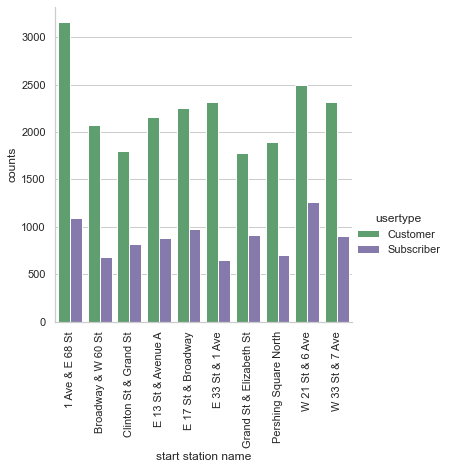

In [53]:
ss_utype_plot = sns.catplot(x="start station name",
                            y="counts",
                            kind="bar", 
                            hue="usertype", 
                            palette={"Customer": "g", "Subscriber": "m"},
                            data=ss_utype)
ss_utype_plot.set_xticklabels(rotation=90)

**Observations:**
1.   There are significantly more customers than there are subscribers in all stations.
2.   1 Ave & E 68 St has the most customers while W 21 St & 6 Ave has the most subscribers.
3.   Grand St & Elizabeth St Station has the most subscribers in proportion to customers.

### Bivariate 4: End station & user type

In [54]:
# Get 10 end stations with the most trips
es = data["end station name"].value_counts().rename_axis('Stations').reset_index(name='counts').nlargest(10, 'counts')

# get rows where these end staions exist, then get the number of trips by usertype
es_utype_df = data[data["end station name"].isin(es['Stations'])].groupby(['end station name','usertype']).agg('count')
es_utype_df = es_utype_df['bikeid'].reset_index(name='Counts')
es_utype_df = es_utype_df.rename(columns={'end station name' : 'End Station', 'usertype' : 'Users'})

es_utype_df

,End Station,Users,Counts
0,1 Ave & E 68 St,Customer,3190
1,1 Ave & E 68 St,Subscriber,1036
2,Broadway & W 60 St,Customer,2107
3,Broadway & W 60 St,Subscriber,682
4,Clinton St & Grand St,Customer,1828
5,Clinton St & Grand St,Subscriber,783
6,E 13 St & Avenue A,Customer,2139
7,E 13 St & Avenue A,Subscriber,904
8,E 17 St & Broadway,Customer,2411
9,E 17 St & Broadway,Subscriber,1070


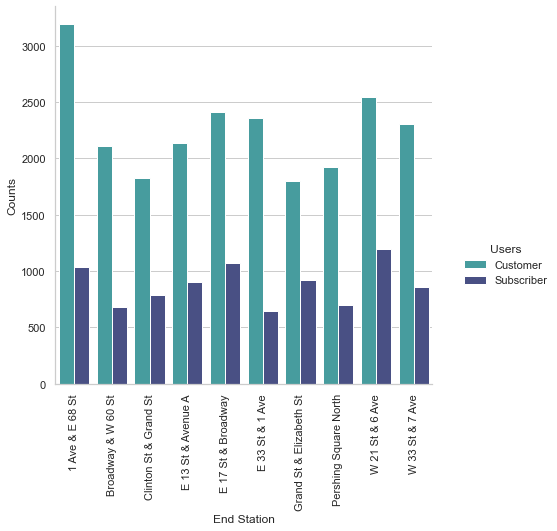

In [55]:
end_station_user_plot = sns.catplot(y="Counts", 
                               x="End Station", 
                               kind="bar", 
                               hue="Users",
                               palette=sns.color_palette("mako_r", 2), 
                               data=es_utype_df)
end_station_user_plot.fig.set_size_inches(8, 6)
end_station_user_plot.set_xticklabels(rotation=90)

**Observations:**
1. For all stations, there are more customers than subscribers.
2. Grand St & Elizabeth St Station has the most subscribers in proportion to customers.
3. E 33 St & 1 Ave Station has the least subscribers in proportion to customers.

### Bivariate 5: End Station & Gender

In [56]:
end_stations = data["end station name"].value_counts().rename_axis('Station name').reset_index(name='counts')
end_stations = end_stations.nlargest(10, 'counts')

In [57]:
end_station_data = data[data["end station name"].isin(end_stations["Station name"])]
end_station_data = end_station_data.groupby(['end station name','gender']).agg('count')
end_station_data = end_station_data["bikeid"].reset_index(name='Counts')
end_station_data = end_station_data.rename(columns={'end station name' : 'End Station', 'gender' : 'Gender'})

In [58]:
end_station_data_valgender = end_station_data[end_station_data["Gender"].isin([1,2])]
end_station_data_valgender

,End Station,Gender,Counts
1,1 Ave & E 68 St,1,661
2,1 Ave & E 68 St,2,370
4,Broadway & W 60 St,1,500
5,Broadway & W 60 St,2,194
7,Clinton St & Grand St,1,504
8,Clinton St & Grand St,2,282
10,E 13 St & Avenue A,1,705
11,E 13 St & Avenue A,2,247
13,E 17 St & Broadway,1,768
14,E 17 St & Broadway,2,310


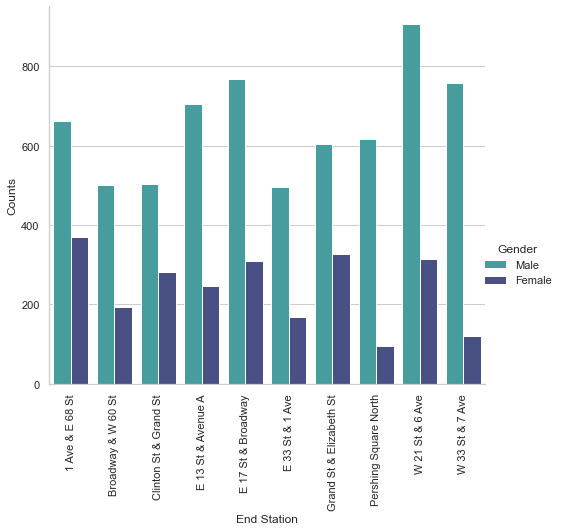

In [59]:
endstation_valgender_plot = sns.catplot(y="Counts", 
                               x="End Station", 
                               kind="bar", 
                               hue="Gender",
                               palette=sns.color_palette("mako_r", 2), 
                               data=end_station_data_valgender,
                               legend_out = True)
new_labels = ['Male', 'Female']
for t, l in zip(endstation_valgender_plot._legend.texts, new_labels): t.set_text(l)
endstation_valgender_plot.fig.set_size_inches(8, 6)
endstation_valgender_plot.set_xticklabels(rotation=90)

**Observations**
1. For the 10 most active end stations, there are more male customers than female customers
2. The difference between number of male and female varies from station to station, with Grand St & Elizabeth St having a female customer count slightly higher than half the male customer count at the low end while W 33 St & 7 Ave has almost 6 times as much male customers as female customers 
3. The stations with the most customers don't necessarily have the most number of males and females, as per observation #2

### Multivariate 1: Start station, end station, & trip duration

In [60]:
od_t = data.groupby(['start station name', 'end station name'], as_index=False).agg({'tripduration':'mean'})
od_t = od_t.rename(columns={"start station name": "start", "end station name": "end", "tripduration": "avg_trip_duration"}, errors="raise")
od_t

,start,end,avg_trip_duration
0,1 Ave & E 110 St,1 Ave & E 110 St,656.235294
1,1 Ave & E 110 St,1 Ave & E 68 St,874.090909
2,1 Ave & E 110 St,1 Ave & E 78 St,557.000000
3,1 Ave & E 110 St,1 Ave & E 94 St,4329.000000
4,1 Ave & E 110 St,2 Ave & E 104 St,187.500000
...,...,...,...
164369,Wythe Ave & Metropolitan Ave,Willoughby Ave & Tompkins Ave,1222.500000
164370,Wythe Ave & Metropolitan Ave,Willoughby Ave & Walworth St,919.000000
164371,Wythe Ave & Metropolitan Ave,Willoughby St & Fleet St,973.000000
164372,Wythe Ave & Metropolitan Ave,Wyckoff Av & Stanhope St,1123.000000


In [61]:
od_t_10 = od_t[od_t.start.isin(start_stations["Station name"]) & od_t.end.isin(end_stations["Station name"])]
od_t_10

,start,end,avg_trip_duration
2318,1 Ave & E 68 St,1 Ave & E 68 St,1876.931034
2433,1 Ave & E 68 St,Broadway & W 60 St,746.864865
2451,1 Ave & E 68 St,Clinton St & Grand St,1540.000000
2482,1 Ave & E 68 St,E 13 St & Avenue A,1350.125000
2489,1 Ave & E 68 St,E 17 St & Broadway,1460.111111
...,...,...,...
145506,W 33 St & 7 Ave,E 33 St & 1 Ave,527.309179
145574,W 33 St & 7 Ave,Grand St & Elizabeth St,1259.250000
145621,W 33 St & 7 Ave,Pershing Square North,447.290323
145660,W 33 St & 7 Ave,W 21 St & 6 Ave,478.238095


In [62]:
od_t_matrix = pd.pivot_table(od_t_10, index='start', columns='end', values='avg_trip_duration')
od_t_matrix

end,1 Ave & E 68 St,Broadway & W 60 St,Clinton St & Grand St,E 13 St & Avenue A,E 17 St & Broadway,E 33 St & 1 Ave,Grand St & Elizabeth St,Pershing Square North,W 21 St & 6 Ave,W 33 St & 7 Ave
start,,,,,,,,,,
1 Ave & E 68 St,1876.931034,746.864865,1540.000000,1350.125000,1460.111111,863.363636,1913.692308,806.461538,1443.000000,1291.919355
Broadway & W 60 St,739.285714,2351.314607,2309.000000,NaN,1576.000000,627.000000,2757.000000,752.888889,956.000000,631.333333
Clinton St & Grand St,NaN,2163.000000,1081.731959,521.500000,1017.454545,43872.000000,465.988889,1514.000000,1311.750000,NaN
E 13 St & Avenue A,1180.900000,NaN,931.666667,1053.457944,569.600000,479.000000,699.818182,956.666667,699.400000,944.600000
E 17 St & Broadway,1506.750000,1174.666667,944.444444,690.195652,941.666667,785.181818,850.250000,693.700000,479.128205,545.923077
E 33 St & 1 Ave,792.125000,1790.000000,1424.000000,599.913043,645.906250,992.984375,1203.500000,499.595238,739.062500,522.422111
Grand St & Elizabeth St,1761.000000,NaN,408.500000,909.000000,837.533333,1318.500000,894.300000,NaN,1104.250000,NaN
Pershing Square North,728.677419,798.111111,1270.333333,993.375000,4099.600000,490.416667,NaN,706.444444,677.363636,482.738095
W 21 St & 6 Ave,1474.000000,1070.250000,1361.000000,677.263158,365.480000,633.750000,1225.625000,698.400000,1053.565217,492.333333


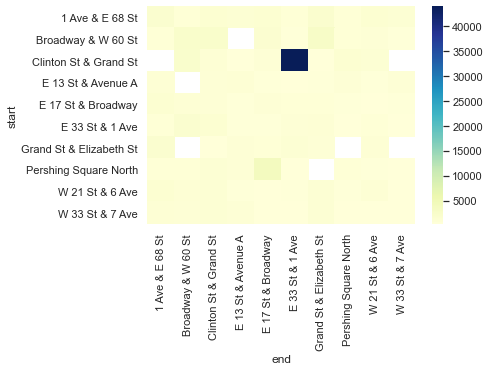

In [63]:
od_t_heatmap = sns.heatmap(od_t_matrix, cmap="YlGnBu")

**Observations:**

In the heat map produced, the average trip duration between stations cannot be represented correctly because of the one value that is significantly higher than the others.

### Multivariate 2: Start station, end station & unique users

Similar to the heat matrix for `total trips` in `origin-destination pairs`, but `count the unique users (bikeid)` instead

In [64]:
# total trips count
od_trips.head()

,start,end,total_trips,od
0,1 Ave & E 110 St,1 Ave & E 110 St,17,1 Ave & E 110 St to 1 Ave & E 110 St
1,1 Ave & E 110 St,1 Ave & E 68 St,11,1 Ave & E 110 St to 1 Ave & E 68 St
2,1 Ave & E 110 St,1 Ave & E 78 St,1,1 Ave & E 110 St to 1 Ave & E 78 St
3,1 Ave & E 110 St,1 Ave & E 94 St,2,1 Ave & E 110 St to 1 Ave & E 94 St
4,1 Ave & E 110 St,2 Ave & E 104 St,2,1 Ave & E 110 St to 2 Ave & E 104 St


In [65]:
# unique users counts
od_unique = data.groupby(['start station name', 'end station name'], as_index=False)['bikeid'].nunique()
od_unique = od_unique.rename(columns={"start station name": "start", "end station name": "end", "bikeid": "unique_users"}, errors="raise")
od_unique["od"] = od_unique["start"] + " to " + od_unique["end"]
od_unique.head()

,start,end,unique_users,od
0,1 Ave & E 110 St,1 Ave & E 110 St,16,1 Ave & E 110 St to 1 Ave & E 110 St
1,1 Ave & E 110 St,1 Ave & E 68 St,11,1 Ave & E 110 St to 1 Ave & E 68 St
2,1 Ave & E 110 St,1 Ave & E 78 St,1,1 Ave & E 110 St to 1 Ave & E 78 St
3,1 Ave & E 110 St,1 Ave & E 94 St,2,1 Ave & E 110 St to 1 Ave & E 94 St
4,1 Ave & E 110 St,2 Ave & E 104 St,2,1 Ave & E 110 St to 2 Ave & E 104 St


You can already see from the first pair `1 Ave & E 110 St` to `1 Ave & E 110 St` that there is a difference between `number of total trips` and `number of unique users`

Again, it is impossible to create a full od matrix because the dataset is too large, so we only use the top ten start and end stations in terms of number of trips

In [66]:
od_unique_topten = od_unique[od_unique.start.isin(start_stations["Station name"]) & od_unique.end.isin(end_stations["Station name"])]
od_unique_topten.head(5)

,start,end,unique_users,od
2318,1 Ave & E 68 St,1 Ave & E 68 St,79,1 Ave & E 68 St to 1 Ave & E 68 St
2433,1 Ave & E 68 St,Broadway & W 60 St,37,1 Ave & E 68 St to Broadway & W 60 St
2451,1 Ave & E 68 St,Clinton St & Grand St,2,1 Ave & E 68 St to Clinton St & Grand St
2482,1 Ave & E 68 St,E 13 St & Avenue A,8,1 Ave & E 68 St to E 13 St & Avenue A
2489,1 Ave & E 68 St,E 17 St & Broadway,9,1 Ave & E 68 St to E 17 St & Broadway


Text(0.5, 1.0, 'Total trips in the top ten stations')

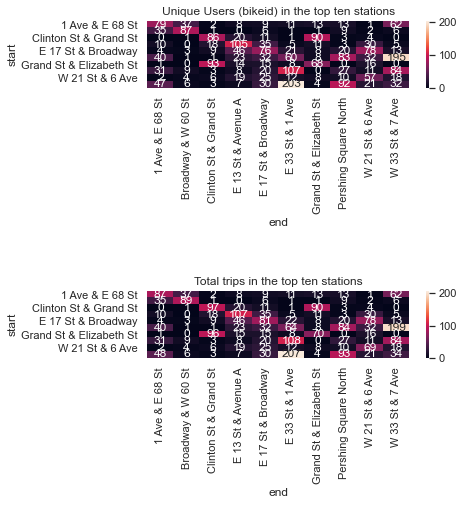

In [67]:
od_unique_matrix = pd.pivot_table(od_unique_topten, index='start', columns='end', values='unique_users', aggfunc=np.sum, fill_value=0)

fig, ax = plt.subplots(2,1, figsize=(10, 10))
fig.tight_layout(pad=15.0) 
od_unique_heatmap = sns.heatmap(od_unique_matrix, ax=ax[0], annot=True, fmt="d")
od_unique_heatmap.set_title('Unique Users (bikeid) in the top ten stations')
od_heatmap = sns.heatmap(od_matrix, ax=ax[1], annot=True, fmt="d")
od_heatmap.set_title('Total trips in the top ten stations')

In the top ten origin-destination pairs pairs:

1. The differences between `total number of trips` and `total number of unique users` are very minimal if not negligible. 
2. `Origin-destination pairs` with low `number of total trips` tend to have the same `number of unique users` and `number of total trips`.

### Multivariate 3: Start station, end station & user type

In [68]:
filtered_ss = (data['start station name'].isin(start_stations['Station name']))
filtered_es = (data['end station name'].isin(end_stations['Station name']))

station_utype = data[filtered_ss & filtered_es]
station_utype = station_utype.groupby(['start station name','end station name'], as_index=False).agg({'usertype':'count'})

station_utype

,start station name,end station name,usertype
0,1 Ave & E 68 St,1 Ave & E 68 St,87
1,1 Ave & E 68 St,Broadway & W 60 St,37
2,1 Ave & E 68 St,Clinton St & Grand St,2
3,1 Ave & E 68 St,E 13 St & Avenue A,8
4,1 Ave & E 68 St,E 17 St & Broadway,9
...,...,...,...
87,W 33 St & 7 Ave,E 33 St & 1 Ave,207
88,W 33 St & 7 Ave,Grand St & Elizabeth St,4
89,W 33 St & 7 Ave,Pershing Square North,93
90,W 33 St & 7 Ave,W 21 St & 6 Ave,21


In [69]:
station_utype_matrix = pd.pivot_table(station_utype, index='start station name', columns='end station name', values='usertype')
station_utype_matrix

end station name,1 Ave & E 68 St,Broadway & W 60 St,Clinton St & Grand St,E 13 St & Avenue A,E 17 St & Broadway,E 33 St & 1 Ave,Grand St & Elizabeth St,Pershing Square North,W 21 St & 6 Ave,W 33 St & 7 Ave
start station name,,,,,,,,,,
1 Ave & E 68 St,87.0,37.0,2.0,8.0,9.0,11.0,13.0,13.0,1.0,62.0
Broadway & W 60 St,35.0,89.0,1.0,NaN,6.0,1.0,1.0,9.0,2.0,6.0
Clinton St & Grand St,NaN,1.0,97.0,20.0,11.0,1.0,90.0,3.0,4.0,NaN
E 13 St & Avenue A,10.0,NaN,18.0,107.0,35.0,5.0,11.0,3.0,30.0,5.0
E 17 St & Broadway,4.0,3.0,9.0,46.0,81.0,22.0,8.0,20.0,78.0,13.0
E 33 St & 1 Ave,40.0,1.0,1.0,23.0,32.0,64.0,8.0,84.0,32.0,199.0
Grand St & Elizabeth St,1.0,NaN,96.0,15.0,15.0,8.0,70.0,NaN,16.0,NaN
Pershing Square North,31.0,9.0,3.0,8.0,20.0,108.0,NaN,27.0,11.0,84.0
W 21 St & 6 Ave,2.0,4.0,6.0,19.0,25.0,12.0,8.0,10.0,69.0,18.0


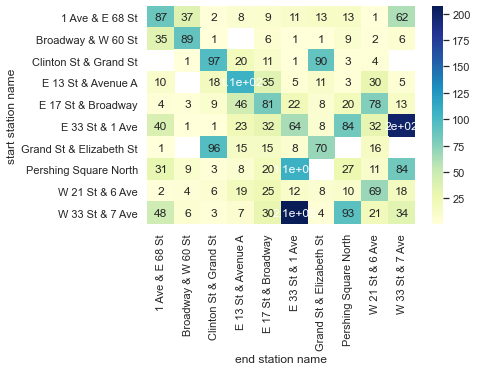

In [70]:
station_utype_heatmap = sns.heatmap(station_utype_matrix, cmap='YlGnBu', annot=True)

**Observations:**
1.   The stations with the most number of trips were taken by customers from W 33 St & 7 Ave to E 33 St & 1 Ave.
2.   The origin-destination pairs that had the most trips were W 33 St & 7 Ave to E 33 St & 1 Ave and E 33 St & 1 Ave to W 33 St & 7 Ave.

### Multivariate 4: Trip distance, duration & gender

In [71]:
# get trip distance values within 2 standard deviations
z_scores = zscore(data["distance_km"]) 
filtered_dist = (np.abs(z_scores) < 2) 

In [72]:
# get trip duration values within 2 standard deviations
z_scores = zscore(data["duration_min"]) 
filtered_entries = (np.abs(z_scores) < 2) 

In [73]:
# get genders that are not unknown
filtered_genders = (data["gender"] > 0) 

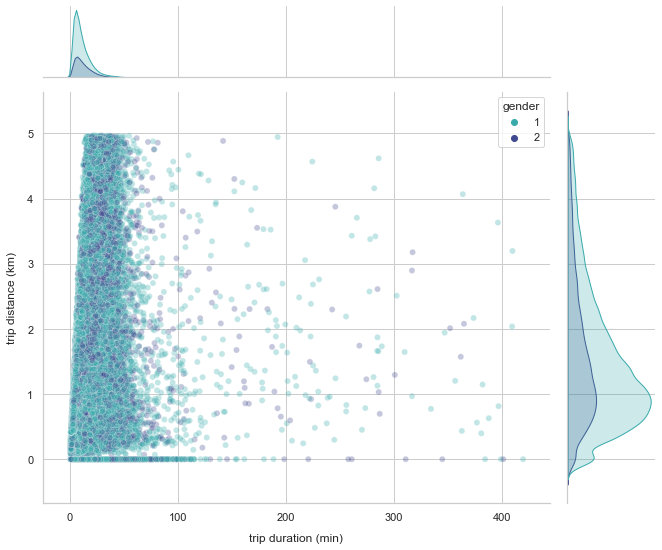

In [74]:
dur_dist_gender_plot = sns.jointplot(
    data=data[filtered_entries & filtered_dist & filtered_genders], x="duration_min", y="distance_km",
    hue="gender",
    palette=sns.color_palette("mako_r", 2),
    alpha=0.3
)
dur_dist_gender_plot.set_axis_labels("trip duration (min)", "trip distance (km)", labelpad=10)
dur_dist_gender_plot.fig.set_size_inches(10, 8)

**Observations:**

1. Most trip duarations are clustered within 100 minutes and 5 km.
2. There is a trend between the trip distance and duration. As the distance increases, the duration also increases.
3. Males are traveling longer distances and longer durations than females.

### Multivariate 5: Average trip distance per unique user, average duration per unique user & user type


In [75]:
z_scores = zscore(data["duration_min"]) 
abs_z_scores = np.abs(z_scores)
filtered_duration = (abs_z_scores < 3) 
data[filtered_duration].shape

(634007, 21)

In [76]:
z_scores = zscore(data["distance_km"]) 
abs_z_scores = np.abs(z_scores)
filtered_distance = (abs_z_scores < 3) 
data[filtered_distance].shape

(622639, 21)

In [77]:
#filter outliers from data
filtered_data = data[filtered_duration & filtered_distance]

In [78]:
atd_ad_ut_data = filtered_data.groupby(['bikeid']).agg({"distance_km":"mean", 
                                               "duration_min":"mean", 
                                               "usertype":lambda x: x.value_counts().index[0]})
atd_ad_ut_data = atd_ad_ut_data.rename(columns={'distance_km' : 'avg_distance_km', 'duration_min' : 'avg_duration_min'})

In [79]:
atd_ad_ut_data

,avg_distance_km,avg_duration_min,usertype
bikeid,,,
14534,1.582827,9.266667,Customer
14536,0.722067,9.805556,Subscriber
14555,1.067159,6.888889,Customer
14559,1.599741,11.383333,Customer
14576,1.470918,11.527778,Customer
...,...,...,...
50103,1.909773,10.609583,Customer
50106,1.258313,8.755208,Customer
50123,2.179735,18.457692,Customer


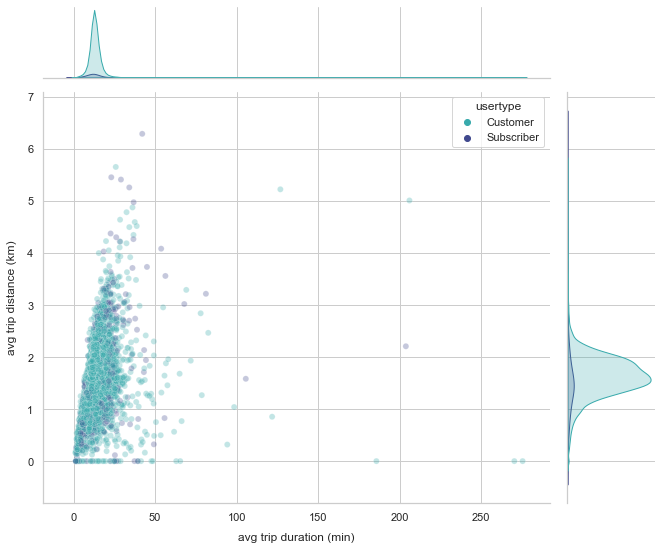

In [80]:
atd_ad_ut_plot = sns.jointplot(
                    data=atd_ad_ut_data,
                    x="avg_duration_min",
                    y="avg_distance_km",
                    hue="usertype",
                    palette=sns.color_palette("mako_r", 2),
                    alpha=0.3
                )
atd_ad_ut_plot.set_axis_labels("avg trip duration (min)", "avg trip distance (km)", labelpad=10)
atd_ad_ut_plot.fig.set_size_inches(10, 8)

There are many outliers at the average duration, but not in distance, likely because delays and accidents only affect duration while distance is static. We will limit the plot at the x-axis to view the data without the outliers

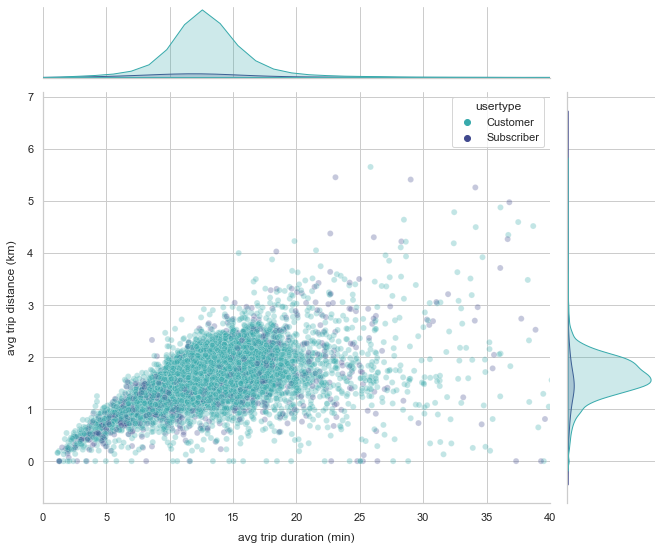

In [81]:
atd_ad_ut_plot = sns.jointplot(
                    data=atd_ad_ut_data,
                    x="avg_duration_min",
                    y="avg_distance_km",
                    hue="usertype",
                    palette=sns.color_palette("mako_r", 2),
                    alpha=0.3,
                    xlim=(0,40)
                )
atd_ad_ut_plot.set_axis_labels("avg trip duration (min)", "avg trip distance (km)", labelpad=10)
atd_ad_ut_plot.fig.set_size_inches(10, 8)

**Observation**
1. Subscribers have high representation at both extremes of the metrics. There are many with low average trip durations and distances, but there are also many with high average trip durations and distances. There are almost none in the middle compared to the number of non-subscriber passengers.
2. Non-subscriber mostly have the average of the average trip duration and distances

### Multivariate 6: Average trip distance per unique user, average duration per unique user, gender & user type

In [82]:
atd_ad_ut_g_data = filtered_data.groupby(['bikeid']).agg({"distance_km":"mean", 
                                               "duration_min":"mean", 
                                               "usertype":lambda x: x.value_counts().index[0],
                                               "gender":lambda x: x.value_counts().index[0]})
atd_ad_ut_g_data = atd_ad_ut_g_data[atd_ad_ut_g_data["gender"].isin([1,2])]
atd_ad_ut_g_data = atd_ad_ut_g_data.rename(columns={'distance_km' : 'avg_distance_km', 'duration_min' : 'avg_duration_min'})

In [83]:
atd_ad_ut_g_data

,avg_distance_km,avg_duration_min,usertype,gender
bikeid,,,,
14536,0.722067,9.805556,Subscriber,1
14613,2.331206,14.913889,Subscriber,2
14653,2.023424,20.916667,Subscriber,2
14656,0.969089,6.270833,Subscriber,1
14658,2.525817,12.466667,Customer,1
...,...,...,...,...
49753,1.820100,13.963889,Subscriber,1
49950,1.988323,14.891228,Subscriber,1
50081,0.735701,5.166667,Subscriber,2


Text(0, 0.5, 'avg trip distance (km)')

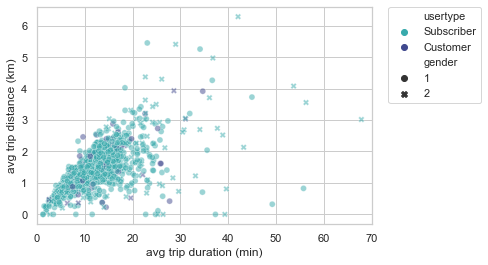

In [84]:
atd_ad_ut_g_plot = sns.scatterplot(
                    data=atd_ad_ut_g_data,
                    x="avg_duration_min",
                    y="avg_distance_km",
                    hue="usertype",
                    palette=sns.color_palette("mako_r", 2),
                    style="gender",
                    alpha=0.5,
                )
atd_ad_ut_g_plot.set(xlim=(0, 70))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("avg trip duration (min)")
plt.ylabel("avg trip distance (km)")

**Observation**
1. Considering the lower proportion of females, there are a lot of females that have high average trip durations distances
2. Subscribers and customers with the highest average trip durations and distances are female
3. Customers with mean average trip durations distances are mostly male subscribers (though this may be inaccurate because the majority of non-subscriber customers have no gender data), though it is surprising that there are almost no non-subscriber customers where the plot is densest